In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
import pandas as pd

import sys
sys.path.append('../../')
from scCustomFunctions import *
from parameters import *
from pipelines import *

from sklearn import preprocessing

import os

#import pydpc

import warnings
warnings.filterwarnings('ignore')

In [2]:
adata = scp.read("data/qc.h5ad")

# Parameters to control de repetition of the analysis

The following variables activate the parts of the code that are used to generate the annotation files to be employed to annotate the clusters. 

Set it to `True` if you want to make new clusterings and anotations. Set them to `False` otherwise.

If the analysis in the previous steps has been performed with the default parameters, setting the reclustering to `True` shouldn't change anything at all.

In [15]:
recluster = False
redo_annotation_files = False
reannotate = True

folder = "./Results/"
annotation_file = "Annotation_2022_03b.csv"
annotation_excel = "Annotation_2022_03.xlsx"

# Clustering

We cluster the different stages using a the following algorithms:

1. Louvain


In [23]:
d = pd.read_csv(folder+"Clusters_2022_03.csv")
d["Louvain"].unique()

array([ 1,  0,  4,  3,  5,  2,  8,  6, 10, 12, 13,  7, 11,  9, 14, 15, 16,
       17, 22, 25, 23, 19, 20, 18, 21, 24, 26, 27])

In [25]:
adata.obs["Louvain_Stage"].unique()

array(['1', '0', '4', '3', '5', '2', nan, '8', '6', '10', '12', '13', '7',
       '11', '9', '14', '15', '16', '17', '22', '25', '23', '19', '20',
       '18', '21', '24', '26', '27'], dtype=object)

In [13]:
if recluster:
    #Compute clustering by batches
    louvain_batches(adata,
                   neighbors_key = "Neighbors_Stage",
                   resolution = LOUVAIN_RESOLUTION)
    #Save obs
    d = adata.obs.loc[:,["Cell","Louvain_Stage"]]
    d["Annotation_Stage"] = ""
    d.to_csv(folder+"Annotation.csv")
else:
    #Load cluters
    clusters_file = pd.read_csv(folder+annotation_file)
    #Find common cells
    d = pd.merge(adata.obs.loc[:,"Cell"], clusters_file, how='inner',on=["Cell"]).loc[:,["Cell","Louvain_Stage","Annotation_Stage"]].set_index("Cell")
    #Set index by cell
    adata.obs.set_index("Cell",inplace=True)
    #Assign clusters to common cells in new and old clusters
    adata.obs.loc[d.index,"Louvain_Stage"] = d.loc[:,"Louvain_Stage"].values.astype(str)
    #Assign annotations to common cells
    adata.obs.loc[d.index,"Annotation_Stage"] = d.loc[:,"Annotation_Stage"].values.astype(str)
    #Reset original index
    adata.obs.reset_index(inplace=True)

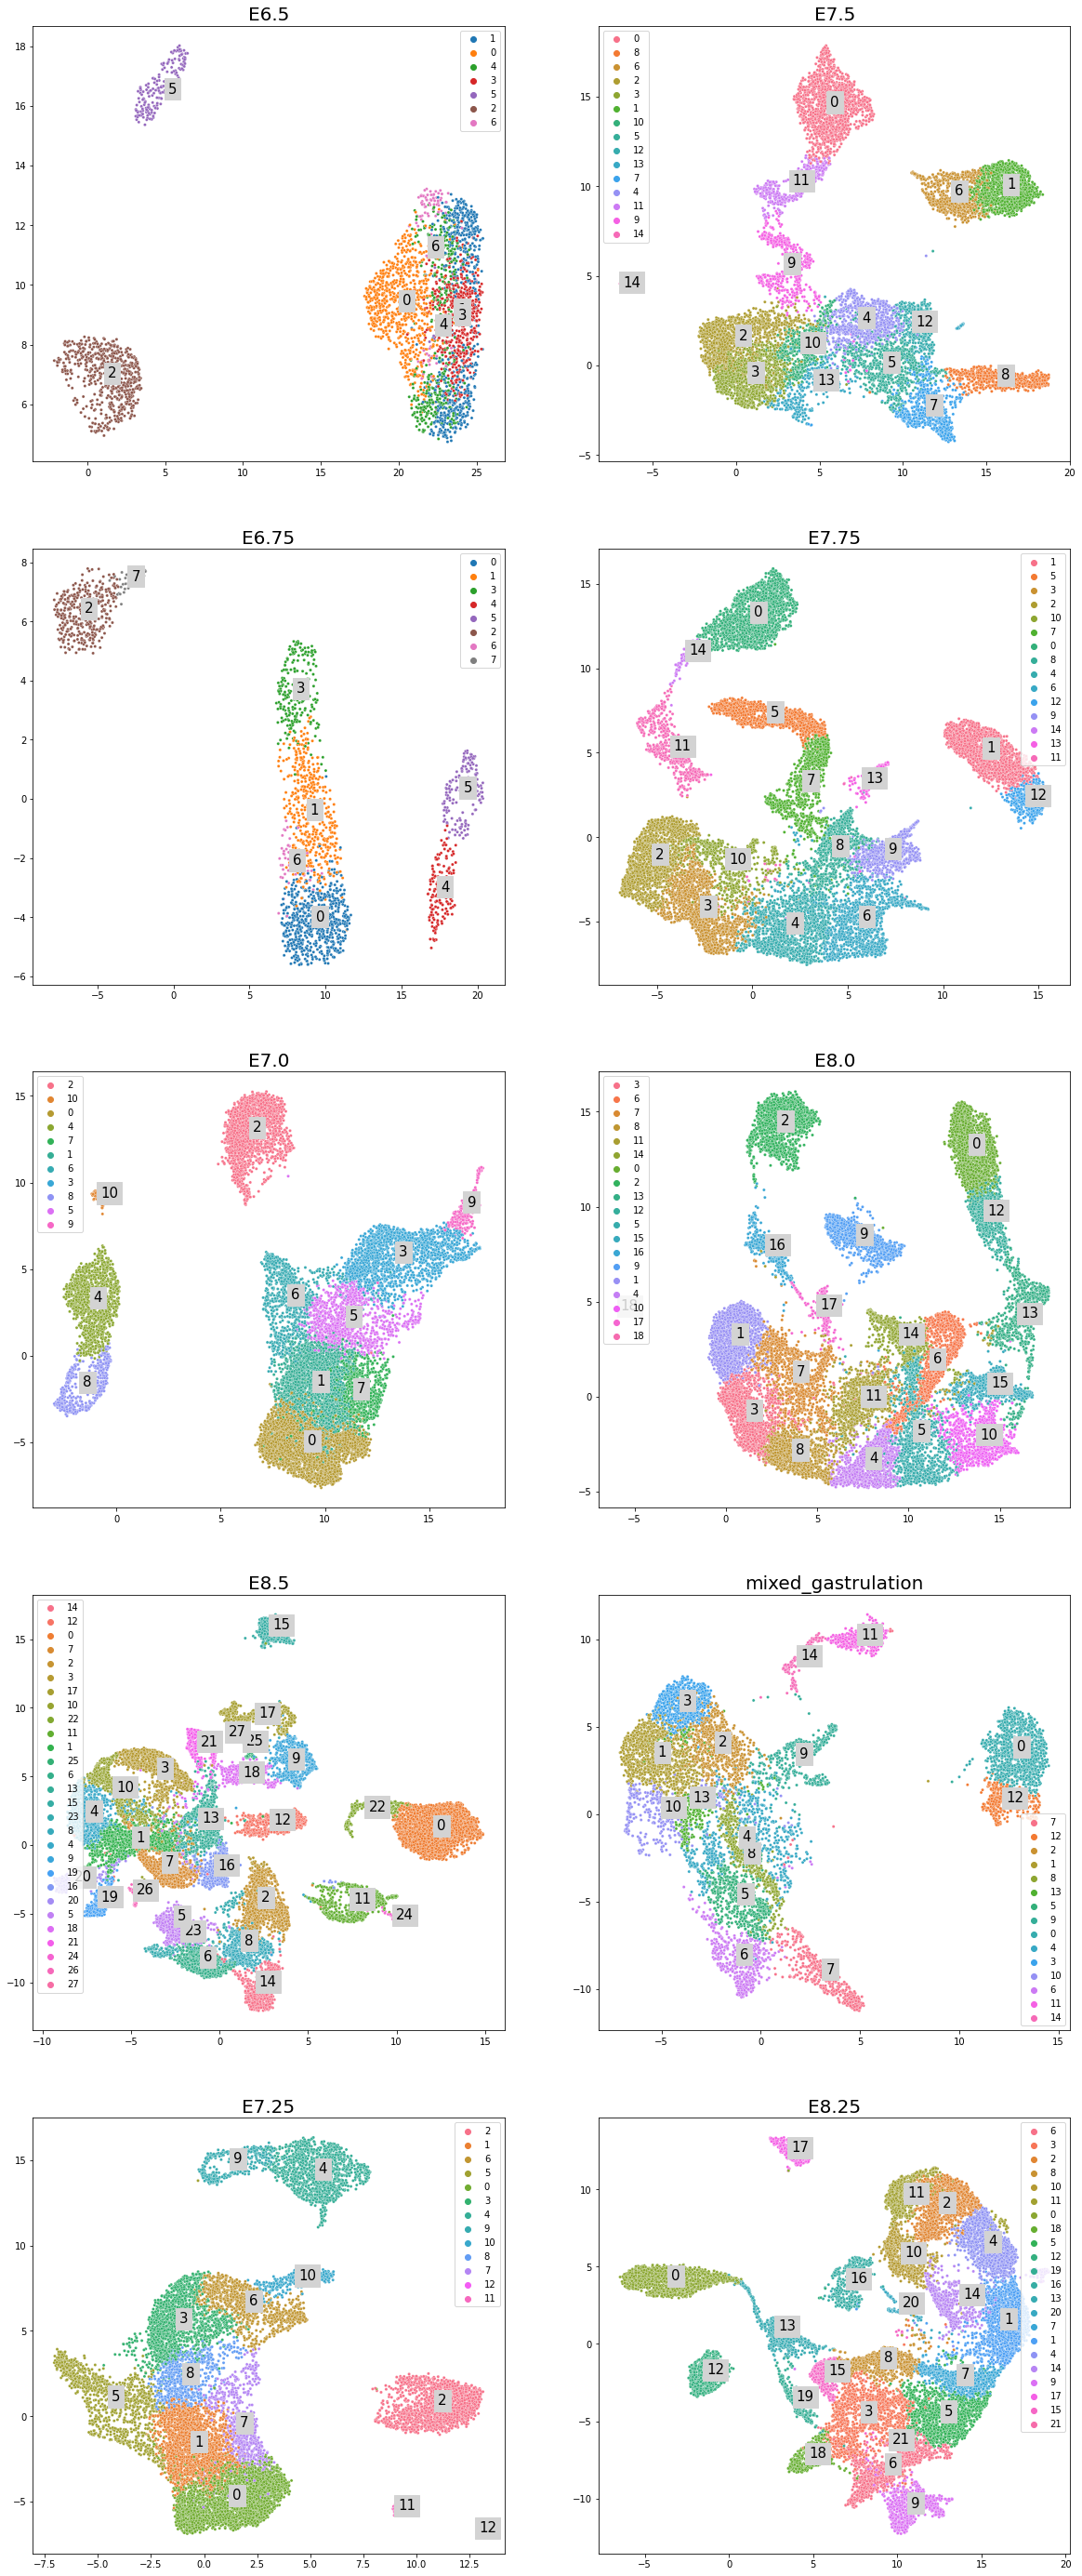

In [14]:
clustering_algorithm = "Louvain_Stage"
representation = "X_umap_Stage"

fig1,ax1 = plt.subplots(5,2,figsize=[20,50])

for j,stage in enumerate(adata.obs["Stage"].unique()[:]):
    
    posx = j//2
    posy = j%2
    
    l = adata.obs.loc[:,"Stage"]==stage    

    t = adata.obs.loc[l,clustering_algorithm].astype(str)
        
    sb.scatterplot(adata.obsm[representation][l,0],adata.obsm[representation][l,1],hue=adata.obs.loc[l,clustering_algorithm].values,s=10,ax=ax1[posx,posy])
    ax1[posx,posy].set_title(stage,fontsize=20)
    for k in t.unique():
        if k != "nan":
            pos = adata.obsm[representation][l,:][t==k,:]
            pos = np.nan_to_num(pos)
            pos = pos.mean(axis=0)
            ax1[posx,posy].text(pos[0],pos[1],k,fontsize=15,backgroundcolor="lightgrey")
            
fig1.savefig("Plots/3_"+clustering_algorithm+"_clusters.png",bbox_inches="tight",transparent=True)

# Annotation

## Create files for manual annotation

For the manual annotation we use the following information:

1. A list of Differentially Expressed genes of each cluster vs. the rest.
2. Plots of gene expression over the UMAP for characteristic genes (to be found in parameters.py).

In [16]:
#Set old annotations to none if there is not a previous annotation of the cells.
if redo_annotation_files:

    rank_genes_excel(adata)
    plot_genes(adata)
    make_empty_annotation(adata,old_annotations=annotations)

## Annotate dataset

After the clusters are annotated. We plot the annotation results over the UMAP

In [17]:
if reannotate:
    ann = pd.read_excel(folder+annotation_excel,sheet_name=None)
    adata.obs["Annotation_Stage"] = ""

    for stage in adata.obs["Stage"].unique():
        b = adata[adata.obs["Stage"]==stage]
        
        print(stage,":",b.obs["Louvain_Stage"].unique())
        for cluster in b.obs["Louvain_Stage"].unique():
            if type(cluster) == str:
                kk = int(cluster)
                adata.obs.loc[b.obs[b.obs["Louvain_Stage"]==cluster].index,"Annotation_Stage"] = ann[stage].loc[kk,"simplified_new_annotation"]

adata.obs

E6.5 : ['1' '0' '4' '3' '5' '2' nan '6']
E7.5 : ['0' '8' '6' '2' '3' '1' '10' '5' nan '12' '13' '7' '4' '11' '9' '14']
E6.75 : ['0' nan '1' '3' '4' '5' '2' '6' '7']
E7.75 : ['1' '5' '3' '2' '10' '7' '0' '8' '4' nan '6' '12' '9' '14' '13' '11']
E7.0 : ['2' '10' '0' '4' '7' '1' '6' '3' nan '8' '5' '9']
E8.0 : ['3' '6' '7' '8' '11' nan '14' '0' '2' '13' '12' '5' '15' '16' '9' '1' '4'
 '10' '17' '18']
E8.5 : ['14' '12' '0' '7' '2' '3' '17' '10' '22' '11' '1' '25' '6' '13' '15' '23'
 '8' '4' '9' '19' '16' nan '20' '5' '18' '21' '24' '26' '27']


KeyError: 26

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'Manual_Annotation' as categorical


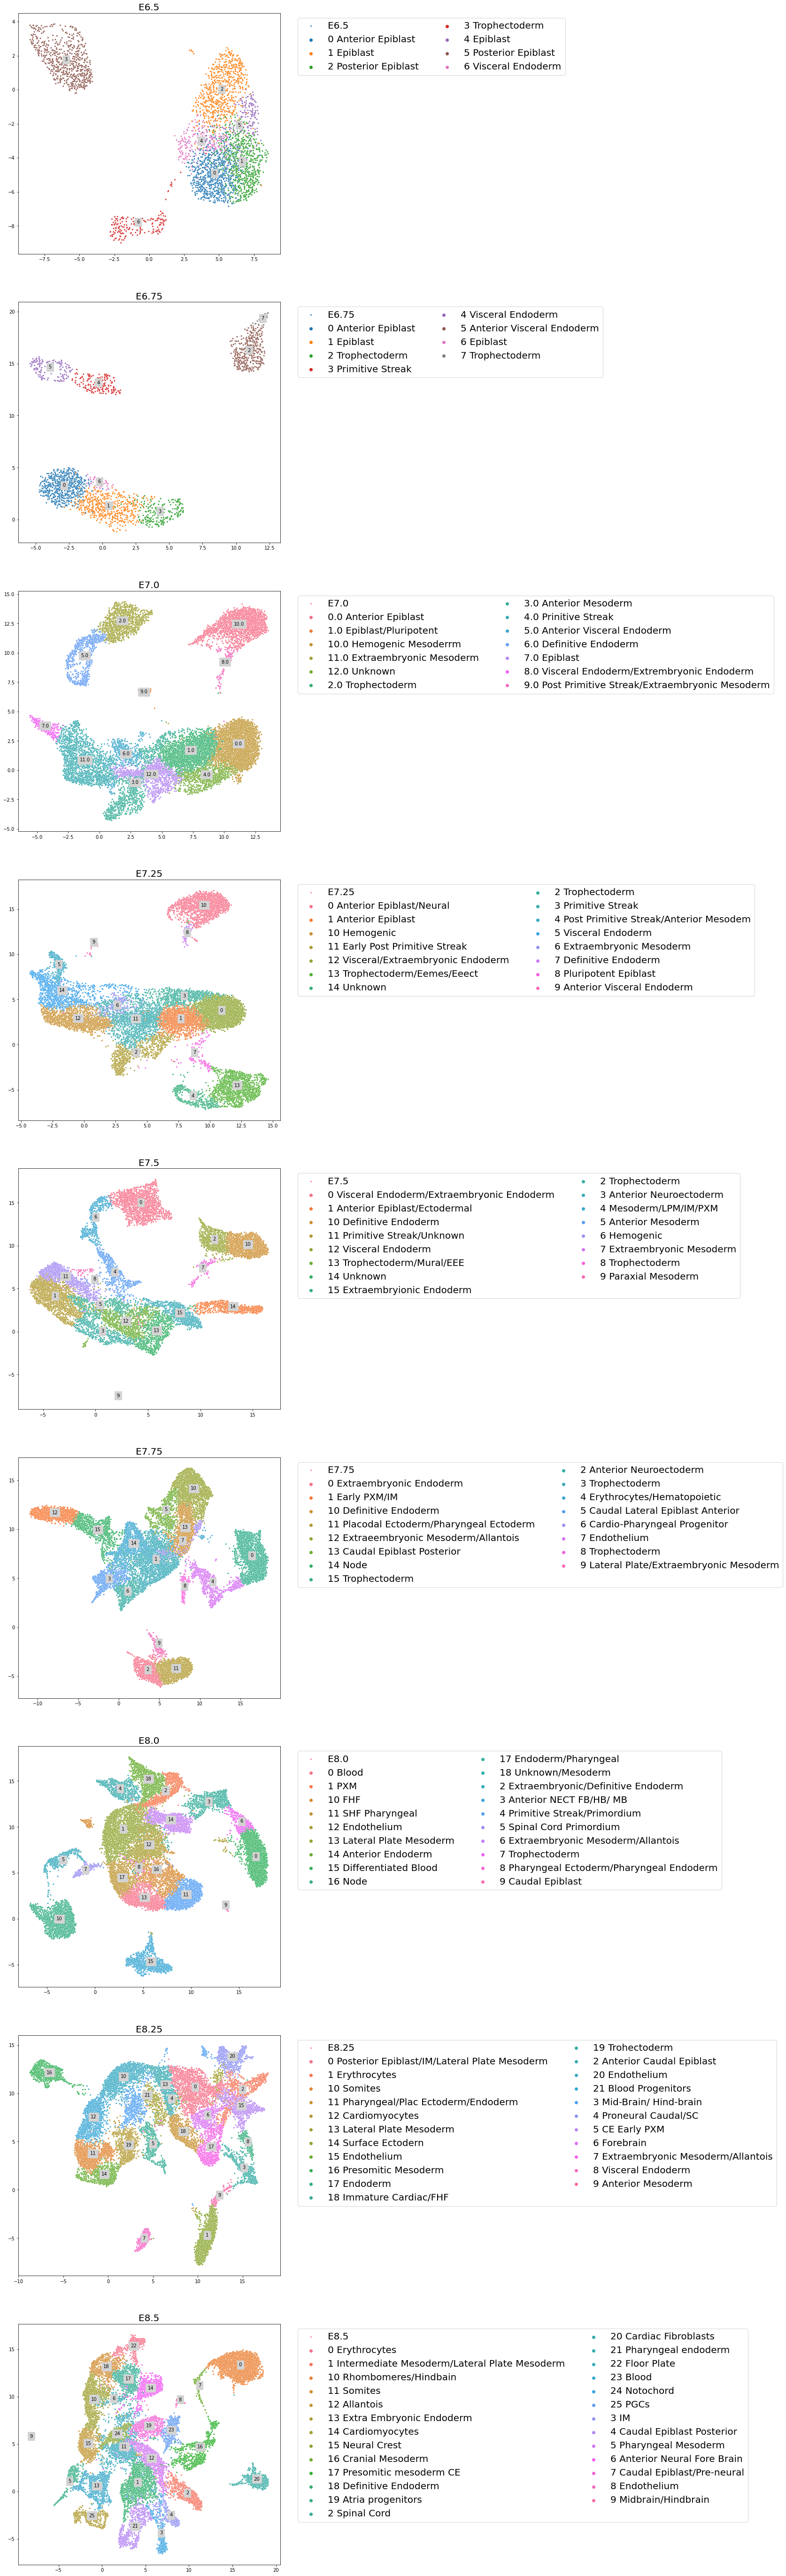

In [8]:
ann = pd.read_excel("./Annotations/Annotations_2022_03.xlsx",sheet_name=None)

fig1,ax1 = plt.subplots(9,1,figsize=[10,100])

a.obs["Manual_Annotation"] = ""

for j,stage in enumerate(["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"]):
    
    posx = j//1
    posy = j%2
    
    b = a[a.obs["stage"]==stage]
    b.obs["sample"]=b.obs["sample"].astype(str)
        
    #Make scatterplots
    sb.scatterplot(b.obsm["X_umap_harmony_stages"][:,0],b.obsm["X_umap_harmony_stages"][:,1],hue=b.obs["louvain"].astype(str),s=10,ax=ax1[posx])
    ax1[posx].set_title(stage,fontsize=20)
    for k in b.obs["louvain"].unique():
        if k != -1:
            pos = b[b.obs["louvain"]==k,:].obsm["X_umap_harmony_stages"]
            pos = np.nan_to_num(pos)
            pos = pos.mean(axis=0)
            kk = int(k)#int(k.split("_")[-1])
            n = ann[stage].loc[kk,"cluster"]
            if type(n) != str:
                n = str(ann[stage].loc[kk,"cluster"])
            ax1[posx].text(pos[0]-len(n)*0.1,pos[1],n,fontsize=10,backgroundcolor="lightgrey")

            a.obs.loc[b.obs[b.obs["louvain"]==k].index,"Manual_Annotation"] = ann[stage].loc[kk,"simplified_new_annotation"]
        
    ax1[posx].legend([stage,]+[str(i)+" "+str(j) for i,j in zip(ann[stage].loc[:,"cluster"],ann[stage].loc[:,"simplified_new_annotation"])],
                    bbox_to_anchor=(1.05, 1),
                    fontsize=20,
                    ncol=2)
    
a.write("data/qc.h5ad")
fig1.savefig("./Plots/3_Louvain_clusters_annotated.png",bbox_inches="tight",transparent=True)
#plt.close(fig1)

# Comparing Manual annotations with previous annotations from Pijuan-Sala

In [17]:
ann = pd.read_excel("./Annotations/Annotations_2022_03.xlsx",sheet_name=None)

fig1,ax1 = plt.subplots(10,1,figsize=[10,100])

for j,stage in enumerate(["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"]):
    
    posx = j//1
    posy = j%2
    
    b = a[a.obs["stage"]==stage]
    b.obs["sample"]=b.obs["sample"].astype(str)
    
    #Make cluster plots
    for k in b.obs["louvain"].unique():
        kk = int(k.split("_")[-1])
        n = ann[stage].loc[kk,"simplified_new_annotation"]
        if type(n) != str:
            n = str(ann[stage].loc[kk,"Cluster"])
        b.obs.loc[b.obs["louvain"]==k,"Manual_Annotation"] = n
        a.obs.loc[b[b.obs["louvain"]==k,:].obs.index.values.astype(str),"Manual_Annotation"] = n
    
    s = b.obs.groupby(["celltype","Manual_Annotation"]).size().unstack()
    s = (s/s.sum(axis=0)).round(2)

    sb.clustermap(s,annot=True)
    plt.savefig("./Plots/3_CA_Overlap_"+stage+".png")
    plt.close()

    #Make UMAPS
    hue = b.obs["celltype"]
    keep = False*np.ones_like(hue).astype(bool)
    for j in b.obs["celltype"].unique():
        l = (b.obs["celltype"] == j)
        if np.sum(l)/len(l) > 0.02: #Plot only clusters that are relevant in the process
            None
        else:
            hue.replace(j,"other",inplace=True)
                
    pos = np.argsort(hue)
    X = b.obsm["X_umap_harmony_stages"]

    sb.scatterplot(X[pos,0],X[pos,1],hue=hue[pos],s=10,ax=ax1[posx])
    ax1[posx].set_title(stage,fontsize=40)
    ax1[posx].legend(bbox_to_anchor=(1.05, 1))
    
    for l,k in enumerate([ll.get_text() for ll in ax1[posx].legend_.texts]):
        pos = b[hue==k,:].obsm["X_umap_harmony_stages"]
        pos = np.nan_to_num(pos)
        pos = pos.mean(axis=0)
        ax1[posx].text(pos[0],pos[1],l,fontsize=20,backgroundcolor="grey")
        ax1[posx].legend_.texts[l].set_text(str(l)+" "+k)
    
fig1.savefig("./Plots/3_CA_Pijuan_Annotations.png",bbox_inches="tight",transparent=False)
plt.close(fig1)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
